# Deep Image Classification

In this set of lecture notes, we'll work through an applied case study of deep learning for image classification. Like [our last adventure with an image classification task](51-vectorization.ipynb), we'll focus on sign-language classification using convolutional kernels. This time, however, we won't take the kernels as given. Instead, we'll attempt to optimize the kernels as part of the learning process.

Along the way, we'll also study some of the practicalities of working with larger models in torch, including model inspection, GPU acceleration, and data set management.

In [3]:
import torch
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
from torch.nn import Conv2d, MaxPool2d, Parameter
from torch.nn.functional import relu
from torchviz import make_dot, make_dot_from_trace
from sklearn.metrics import confusion_matrix

## A Note On Chips 

As we've seen from the last several lectures, deep learning models involve a **lot** of linear algebra in order to compute predictions and gradients. This means that deep models, even more than many other machine learning models, strongly benefit from hardware that is good at doing linear algebra *fast*. As it happens, graphics processing units (GPUs) are very, very good at fast linear algebra. [The reason that GPUs are so good at this is that they were originally optimized for rendering complex graphics in e.g. animation and video games, and this involves lots of linear algebra.]{.aside} So, it's very helpful when running our models to have access to GPUs; using a GPU can often result in up to 10x speedups. While some folks can use GPUs on their personal laptops, another common option for learning purposes is to use a cloud-hosted GPU. My personal recommendation is Google Colab, and I'll supply links that allow you to open lecture notes in Colab and use their GPU runtimes. 

The following torch code checks whether there is a GPU available to Python, and if so, sets a variable called `device` to log this fact. We'll make sure that both our data and our models fully live on the same device when doing model training. 

In [4]:
#---
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on {device}.")
#---

Running on cpu.


Now let's acquire our data and convert it into a tensor format. We'll continue to work on the [Sign Language MNIST](https://www.kaggle.com/datasets/datamunge/sign-language-mnist) data set, which I retrieved from Kaggle. Our aim is still to train a model that can predict the letter represented by an image of a hand gesture. 

In [5]:
train_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/sign-language-mnist/sign_mnist_train.csv"
test_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/sign-language-mnist/sign_mnist_test.csv"

df_train = pd.read_csv(train_url)
df_val   = pd.read_csv(test_url)

def prep_data(df):
    n, p = df.shape[0], df.shape[1] - 1
    y = torch.tensor(df["label"].values)
    X = df.drop(["label"], axis = 1)
    X = torch.tensor(X.values)
    X = torch.reshape(X, (n, 1, 28, 28))
    X = X / 255

    # important: move the data to GPU if available
    X, y = X.to(device), y.to(device)
    
    return X, y

X_train, y_train = prep_data(df_train)
X_val, y_val     = prep_data(df_val)

Like last time, our data is essentially a big stack of images: 

In [6]:
#---
X_train.size() # (num_images, num_color_channels, num_vertical_pixels, num_horizontal_pixels)
#---

torch.Size([27455, 1, 28, 28])

Here are a few excerpts from the data. 

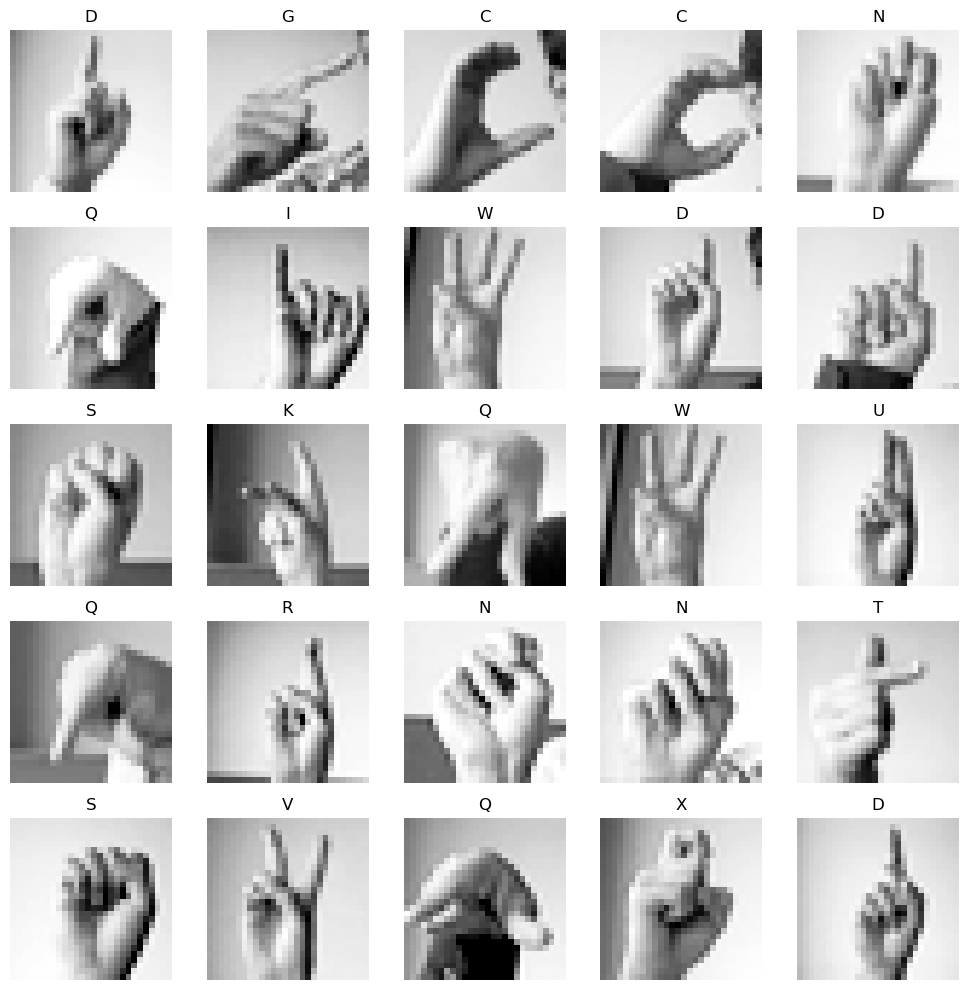

In [7]:
ALPHABET = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"

def show_images(X, y, rows, cols, channel = 0):

    fig, axarr = plt.subplots(rows, cols, figsize = (2*cols, 2*rows))
    for i, ax in enumerate(axarr.ravel()):
        ax.imshow(X[i, channel].detach().cpu(), cmap = "Greys_r")
        ax.set(title = f"{ALPHABET[y[i]]}")
        ax.axis("off")
    plt.tight_layout()

show_images(X_train, y_train, 5, 5)

## Data Loaders 

A *data loader* is an iterator that allows us to retrieve small pieces ("batches") of the data set. This is very convenient for stochastic gradient descent -- we get the piece of the data that we want, compute the loss, compute the gradients, take an optimization step, and then get the next piece of data. Let's put both our training and validation sets into data loaders. 

In [8]:
#---
data_loader_train = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_train, y_train),
    batch_size = 32,
    shuffle = True
)

data_loader_val = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_val, y_val),
    batch_size = 32,
    shuffle = True
)
#---

Here's an example of retrieving a batch of training data from the training data loader: 

In [9]:
#---
X, y = next(iter(data_loader_train))
print(X.size(), y.size())
#---

torch.Size([32, 1, 28, 28]) torch.Size([32])


We most frequently work with data loaders via loops: 

```python
for X, y in data_loader_train: 
    #...
```

An additional benefit of data loaders is that they can perform arbitrary operations in order to return data batches, including reading files from disk. So, if your overall data set is too large to hold in memory, you can write a custom data loader that reads in a batch of files, operates on them in some way, and returns the result to you as a tensor. 

### Interlude: Multiclass Classification

We're actually now making our first formal study of a multiclass classification problem, in which we are trying to distinguish data observations into more than two possible categories. Whereas before we didn't really comment on the specific structure of this problem, here we need to build up a model from scratch and therefore need to understand how it works!

Typically, classification models return a score *for each class*. Then, the class with the highest score is usually considered to be the model's prediction. This means that the score function should actually return a *vector* of scores for each data observation.

In order to make this happen for a single-layer model, we move from a matrix-vector multiplication $\mathbf{X}\mathbf{w}$ to a matrix-matrix multiplication $\mathbf{X}\mathbf{W}$, where $\mathbf{W} \in \mathbb{R}^{p \times r}$ has number of rows equal to the number of features and number of columns equal to the number of classes.

More generally, we can define our model in any way we like, as long as it returns a vector of scores for each data observation.

It is also necessary to modify the loss function for classification models. Instead of the binary cross entropy, we need to define a multiclass generalization. The most common choice of per-observation loss function between a vector of class scores $\mathbf{s} \in \mathbb{R}^r$ and the true label $y_i$ is

$$
\ell(\mathbf{s}_i, y_i) = \sum_{j = 1}^r \mathbb{1}[y_i = j]\log\left(\frac{e^{s_{ij}}}{\sum_{k = 1}^r e^{s_{ik}}}\right)
$$

The function

$$
\mathrm{softmax}(\mathbf{s}) = \left(\begin{matrix}
    \frac{e^{s_1}}{\sum_{j = 1}^r e^{s_j}} \\
    \frac{e^{s_2}}{\sum_{j = 1}^r e^{s_j}} \\
    \vdots \\
    \frac{e^{s_r}}{\sum_{j = 1}^r e^{s_j}}
    \end{matrix}\right)
$$

is a generalization of the logistic sigmoid function to the multiclass setting. It is called the softmax function because it has a tendency to accentuate the largest value in the vector $\mathbf{s}$. With this notation, we can write the cross-entropy loss as

$$
\ell(\mathbf{s}_i, y_i) = \sum_{j = 1}^r \mathbb{1}[y_i = j]\log \mathrm{softmax}(\mathbf{s}_i)_j\;.
$$

Summing the per-observation loss over all data points gives the empirical risk to be minimized.

## A First Linear Model

Let's implement a linear model with the multiclass cross entropy. This first model is equivalent to multiclass logistic regression.


In [10]:
import torch.nn as nn
import torch.nn.functional as F


#---
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.pipeline = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 26)
        )

    # this is the customary name for the method that computes the scores
    # the loss is usually computed outside the model class during the training loop
    def forward(self, x):
        return self.pipeline(x)
        
    def predict(self, x):

        scores = self.forward(x)
        return torch.argmax(scores, dim = 1)

model = LinearModel().to(device)
#---

The `forward` method computes a matrix of scores. Each row of this matrix gives the scores for a single observation:

In [11]:
#---
scores = model(X_train)
scores
#---

tensor([[-0.3941, -0.0619,  0.0479,  ...,  0.3025, -0.7816,  0.7435],
        [-0.3928,  0.2280, -0.1094,  ...,  0.1586, -0.7048,  0.6639],
        [-0.4145,  0.2766, -0.2559,  ...,  0.4418, -0.7350,  0.7060],
        ...,
        [-0.4428, -0.0306, -0.0194,  ...,  0.3720, -0.8557,  0.8584],
        [-0.4483,  0.0069,  0.0106,  ...,  0.1381, -0.9923,  1.0725],
        [-0.3167,  0.0610, -0.0621,  ...,  0.3903, -0.7921,  0.7055]],
       grad_fn=<AddmmBackward0>)

The `predict` method just computes these scores and returns the column index of the largest score in each column.

In [12]:
#---
torch.argmax(scores, dim = 1) # indices of predicted letters
#---

tensor([25, 13, 22,  ..., 25, 25, 13])

It's very useful to get in the habit of *inspecting* your models in order to understand how they are organized and how many parameters need to be trained. One convenient way to do this is with the `summary` function provided by the `torchsummary` package. This function requires that we input the dimensions of a single observation:

In [13]:
#---
from torchsummary import summary
summary(model, input_size=(1, 28, 28))
#---

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 26]          20,410
Total params: 20,410
Trainable params: 20,410
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.08
Estimated Total Size (MB): 0.09
----------------------------------------------------------------


In [15]:
loss_fn = nn.CrossEntropyLoss() 

X, y = next(iter(data_loader_train))
X, y = X.to(device), y.to(device)

s = model(X)
loss = loss_fn(s, y)

make_dot(loss, params=dict(model.named_parameters()))

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

Even this simple multiclass logistic model has over 20,000 parameters to train! Note that the output shape matches the number of possible class labels in the data. 

Let's first implement a function to evaluate the model:

In [90]:
#---
def evaluate(model):
    
    # count the number of total observations and correct predictions
    total = 0
    total_correct = 0
    
    
    # loop through the data loader
    for X, y in data_loader_val:
        
        # move the data to the device (ideally, to gpu)
        X, y = X.to(device), y.to(device)

        # compute the predictions
        scores = model.forward(X)
        y_pred =  torch.argmax(scores, dim = 1)
        
        # update the total and the number of correct predictions
        total += X.size(0)
        total_correct += (y_pred == y).sum().item()
    
    print(f"validation accuracy = {total_correct / total:.3f}")
#--

In [91]:
evaluate(model)

validation accuracy = 0.042



Obviously our model does not do very well on the validation data, since it's not trained yet. 

Let's therefore implement a simple training loop. This loop will include provisions to train the model while also calling the previous function to update us on the  accuracy on the validation set.

In [92]:
import torch.optim as optim
def train(model, k_epochs = 1, print_every = 2000, evaluate_after_epoch = True, **opt_kwargs):
    
    #---
    # loss function is cross-entropy (multiclass logistic)
    loss_fn = nn.CrossEntropyLoss()

    # optimizer is SGD with momentum
    optimizer = optim.SGD(model.parameters(), **opt_kwargs)

    for epoch in range(k_epochs):
        for i, data in enumerate(data_loader_train):
            X, y = data
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad() # clear any accumulated gradients
            y_pred = model(X)
            loss   = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()

            if (i + 1) % print_every == 0:
                print(f"Epoch {epoch}, batch {i:>3}, loss on batch: {loss.item():.3f}")

        if evaluate_after_epoch:
            print(f"Epoch {epoch}: ", end = "")
            evaluate(model)
    #---

In [93]:
train(model, k_epochs = 30, lr = 0.001, evaluate_after_epoch = True)

Epoch 0: validation accuracy = 0.133
Epoch 1: validation accuracy = 0.219
Epoch 2: validation accuracy = 0.284
Epoch 3: validation accuracy = 0.340
Epoch 4: validation accuracy = 0.332
Epoch 5: validation accuracy = 0.397
Epoch 6: validation accuracy = 0.386
Epoch 7: validation accuracy = 0.401
Epoch 8: validation accuracy = 0.417
Epoch 9: validation accuracy = 0.428
Epoch 10: validation accuracy = 0.427
Epoch 11: validation accuracy = 0.430
Epoch 12: validation accuracy = 0.450
Epoch 13: validation accuracy = 0.482
Epoch 14: validation accuracy = 0.482
Epoch 15: validation accuracy = 0.477
Epoch 16: validation accuracy = 0.469
Epoch 17: validation accuracy = 0.500
Epoch 18: validation accuracy = 0.506
Epoch 19: validation accuracy = 0.496
Epoch 20: validation accuracy = 0.507
Epoch 21: validation accuracy = 0.501
Epoch 22: validation accuracy = 0.512
Epoch 23: validation accuracy = 0.517
Epoch 24: validation accuracy = 0.526
Epoch 25: validation accuracy = 0.531
Epoch 26: validation a

## Convolutional Models

Our favorite logistic regression is a great algorithm, but there is lots of room to improve! Last time we studied this data set, we used convolutional kernels extract more helpful features from the data before finally plugging those features into a logistic regression model. Convolutional kernels offer structured transformations that can accentuate certain features of images: 

![](https://d2l.ai/_images/correlation.svg)

*Image from [Dive Into Deep Learning](https://d2l.ai/chapter_convolutional-neural-networks/conv-layer.html)*

We sandwiched those convolutional layers between pooling and ReLU activation layers. This time, instead of treating these kernels as given, we are going to learn them as part of the optimization routine.

*Starting from this point in the notes, it is strongly recommended to run this code with a GPU available, such as in Google Colab*.

In [94]:
import torch.nn as nn
from  torch.nn import ReLU

#---
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.pipeline = torch.nn.Sequential(
            nn.Conv2d(1, 100, 5), 
            ReLU(), 
            nn.Conv2d(100, 50, 3),
            ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(50, 50, 3),
            ReLU(),
            nn.Conv2d(50, 50, 3),
            ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(450, 512),
            ReLU(),
            nn.Linear(512, 128),
            ReLU(),
            nn.Linear(128, len(ALPHABET))
        )
        
    def forward(self, x):
        return self.pipeline(x)

model = ConvNet().to(device)
#---

What does this model look like?

In [95]:
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 100, 24, 24]           2,600
              ReLU-2          [-1, 100, 24, 24]               0
            Conv2d-3           [-1, 50, 22, 22]          45,050
              ReLU-4           [-1, 50, 22, 22]               0
         MaxPool2d-5           [-1, 50, 11, 11]               0
            Conv2d-6             [-1, 50, 9, 9]          22,550
              ReLU-7             [-1, 50, 9, 9]               0
            Conv2d-8             [-1, 50, 7, 7]          22,550
              ReLU-9             [-1, 50, 7, 7]               0
        MaxPool2d-10             [-1, 50, 3, 3]               0
          Flatten-11                  [-1, 450]               0
           Linear-12                  [-1, 512]         230,912
             ReLU-13                  [-1, 512]               0
           Linear-14                  [

This model has (many) more parameters than the logistic regression model. The increased depth, as well as the use of convolutional layers, give it *potential* to usefully leverage the spatial structure of the predictor data. 

In [96]:
train(model, k_epochs = 30,  lr = 0.01, evaluate_after_epoch = True, momentum = 0.9)

Epoch 0: validation accuracy = 0.438
Epoch 1: validation accuracy = 0.808
Epoch 2: validation accuracy = 0.893
Epoch 3: validation accuracy = 0.906
Epoch 4: validation accuracy = 0.906
Epoch 5: validation accuracy = 0.907
Epoch 6: validation accuracy = 0.907
Epoch 7: validation accuracy = 0.906
Epoch 8: validation accuracy = 0.906
Epoch 9: validation accuracy = 0.906
Epoch 10: validation accuracy = 0.906
Epoch 11: validation accuracy = 0.906
Epoch 12: validation accuracy = 0.906
Epoch 13: validation accuracy = 0.906
Epoch 14: validation accuracy = 0.906
Epoch 15: validation accuracy = 0.906
Epoch 16: validation accuracy = 0.906
Epoch 17: validation accuracy = 0.906
Epoch 18: validation accuracy = 0.906
Epoch 19: validation accuracy = 0.906
Epoch 20: validation accuracy = 0.906
Epoch 21: validation accuracy = 0.906
Epoch 22: validation accuracy = 0.906
Epoch 23: validation accuracy = 0.906
Epoch 24: validation accuracy = 0.906
Epoch 25: validation accuracy = 0.906
Epoch 26: validation a

Although this model takes *much* longer to complete a single epoch, it is also able to achieve much higher validation accuracy than the pure logistic regression model (which, as you'll recall from our previous work on this data set, leveled out around 67%). 

## Other Considerations 

We'll highlight two practical considerations that frequently come up when working with image classification models. 

### Data Augmentation

One very standard technique for improving the ability of image classification models to generalize is to perform *data augmentation*. Data augmentation creates "new" data by applying simple transformations to the input images. For example, one kind of data augmentation is to *rotate* the image by a small amount. 

[You can learn more about Torch's data augmentation capabilities in [the documentation](https://pytorch.org/vision/stable/transforms.html)]{.aside}.

Here is an example of applying a data augmentation pipeline to an image. The result is a sequence of new images, which would be reasonably expected to have the same true class label as the original. 

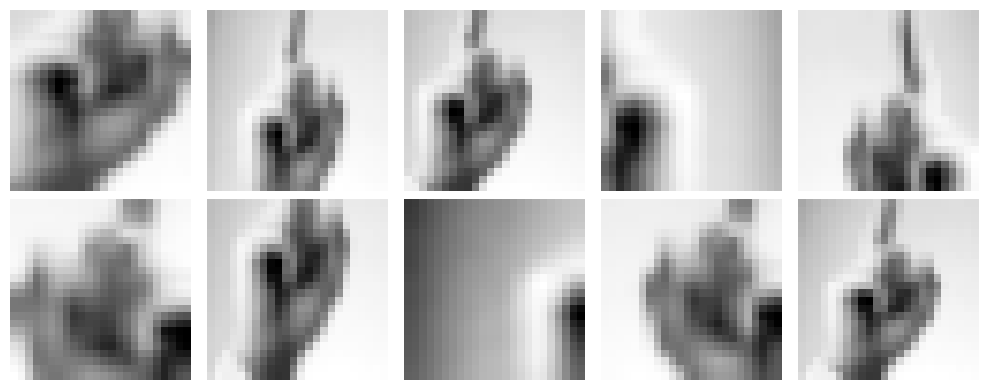

In [97]:
from torchvision.transforms import v2
transforms = v2.Compose([
    v2.RandomResizedCrop(size=(24, 24), antialias=True),
    v2.RandomHorizontalFlip(p=0.5)
    ])

cols = 5
rows = 2
ix = 0

fig, axarr = plt.subplots(rows, cols, figsize = (2*cols, 2*rows))
for i, ax in enumerate(axarr.ravel()):
    transformed = transforms(X_train[ix])
    ax.imshow(transformed.detach().cpu()[0], cmap = "Greys_r")
    ax.axis("off")
plt.tight_layout()

### Data Loaders from Directories

As mentioned above, it can be very helpful to use data loaders to manage the process of reading in data and passing it to your model. This is especially helpful in the case that your data set is too large to fit in RAM; the data loader can read the data from disk and pass it to the model, without ever needing to fit the entirety of data in RAM. You can learn much more about how Torch manages data sets and data loaders in [the docs](https://pytorch.org/docs/stable/data.html#loading-batched-and-non-batched-data).